# Цифровая солидарность в условиях гуманитарного кризиса
## Анализ предложений бесплатного жилья для жителей Курской области на платформе Avito

---

**Контекст исследования:**

В августе 2024 года в связи с военными действиями тысячи жителей Курской области были вынуждены покинуть свои дома. Платформа Avito запустила специальный фильтр для предложений бесплатного временного жилья (#яПомогаю). 

**Цель исследования:**

Изучение проявлений гражданской солидарности через анализ предложений бесплатного жилья: где и на каких условиях люди готовы безвозмездно помогать внутренне перемещенным лицам.

**Исследовательские вопросы:**

1. **География солидарности:** Какие регионы России наиболее активно предлагают помощь?
2. **Условия помощи:** На какие сроки люди готовы предоставлять жилье бесплатно?
3. **Характеристики жилья:** Какие типы жилья предлагаются (квартиры, комнаты, дома)?
4. **Ценовые характеристики:** Какова обычная стоимость предлагаемого жилья?

## Часть 1. Подготовка данных

### 1.1. Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

sns.set_palette("husl")
%matplotlib inline

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

### 1.2. Загрузка данных

In [3]:
df = pd.read_csv('raw_data.csv')
df.head()

,category,url,title,price,rooms,area,address,free_period,time_ago,collection_date
0,apartments,https://www.avito.ru/kurskaya_oblast_zheleznog...,"3-к. квартира, 64 м², 3/5 эт.",20000,3,64.0,"Курская обл., Железногорск, Курская ул., 13к1",Бесплатно более 2 месяцев,2 ноября 13:33,2025-12-14 15:06:31
1,apartments,https://www.avito.ru/kineshma/kvartiry/1-k._kv...,"1-к. квартира, 45 м², 3/5 эт.",35000,1,45.0,"Ивановская обл., Кинешма, ул. Менделеева, 7",Бесплатно более 2 месяцев,8 сентября 21:30,2025-12-14 15:06:35
2,apartments,https://www.avito.ru/mahachkala/kvartiry/1-k._...,"1-к. квартира, 24 м², 1/1 эт.",12000,1,24.0,"Республика Дагестан, Махачкала, Горская ул.",Бесплатно на 1 неделю,23 сентября 2019,2025-12-14 15:06:41
3,apartments,https://www.avito.ru/kazan/kvartiry/2-k._kvart...,"2-к. квартира, 70 м², 7/8 эт.",41000,2,70.0,"Республика Татарстан (Татарстан), Казань, Минс...",Бесплатно более 2 месяцев,12 сентября 16:16,2025-12-14 15:06:47
4,apartments,https://www.avito.ru/orenburg/kvartiry/1-k._kv...,"1-к. квартира, 31 м², 4/9 эт.",17500,1,31.0,"Оренбургская обл., Оренбург, Алтайская ул., 2/2",Бесплатно на 2 недели,3 дня назад,2025-12-14 15:06:53


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         338 non-null    object 
 1   url              338 non-null    object 
 2   title            338 non-null    object 
 3   price            338 non-null    int64  
 4   rooms            176 non-null    object 
 5   area             328 non-null    float64
 6   address          338 non-null    object 
 7   free_period      337 non-null    object 
 8   time_ago         338 non-null    object 
 9   collection_date  338 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 26.5+ KB


### 1.3. Очистка 

In [7]:
def clean_text(text):
    
    if pd.isna(text):
        return text
    if isinstance(text, str):
        text = text.replace('\t', ' ').replace('\n', ' ')
        text = ' '.join(text.split()) 
    return text

text_columns = ['category', 'url', 'title', 'address', 'free_period', 'time_ago']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

### 1.4. Преобразование 

In [8]:
df['collection_date'] = pd.to_datetime(df['collection_date'], errors='coerce')
print(f"Диапазон дат сбора: {df['collection_date'].min()} — {df['collection_date'].max()}")

Диапазон дат сбора: 2025-12-14 15:06:31 — 2025-12-14 15:39:42


In [9]:
print(df['time_ago'].value_counts())

1 неделю назад      11
7 дней назад         9
2 недели назад       9
3 дня назад          7
3 недели назад       7
                    ..
17 февраля 21:01     1
17 апреля 10:24      1
23 августа 2018      1
17 октября 2024      1
26 мая 2014          1
Name: time_ago, Length: 284, dtype: int64


In [12]:
def parse_time_ago(time_ago_str, collection_date):
   
    if pd.isna(time_ago_str) or pd.isna(collection_date):
        return None
    
    time_ago_str = str(time_ago_str).lower().strip()
    
    #Случай: "Вчера"
    if 'вчера' in time_ago_str:
        return collection_date - timedelta(days=1)
    
    #Случай: "Сегодня" или пустая строка
    if 'сегодня' in time_ago_str or time_ago_str == '':
        return collection_date
    
    #Случай: "N дней/дня/день назад"
    days_match = re.search(r'(\d+)\s*(день|дня|дней)\s*назад', time_ago_str)
    if days_match:
        days = int(days_match.group(1))
        return collection_date - timedelta(days=days)
    
    #Случай: "N недель/недели/неделю назад"
    weeks_match = re.search(r'(\d+)\s*(недел[ьюия])\s*назад', time_ago_str)
    if weeks_match:
        weeks = int(weeks_match.group(1))
        return collection_date - timedelta(weeks=weeks)
    
    #Случай: "N месяцев/месяца назад"
    months_match = re.search(r'(\d+)\s*(месяц[аев]?)\s*назад', time_ago_str)
    if months_match:
        months = int(months_match.group(1))
        return collection_date - timedelta(days=months*30)  # Приблизительно
    
    #Случай: конкретная дата (например, "15 октября 12:58" или "6 ноября 2024")
    try:
        #Словарь для перевода месяцев
        months_ru = {
            'января': '01', 'февраля': '02', 'марта': '03', 'апреля': '04',
            'мая': '05', 'июня': '06', 'июля': '07', 'августа': '08',
            'сентября': '09', 'октября': '10', 'ноября': '11', 'декабря': '12'}
        
        #Формат: "15 октября 12:58" 
        match = re.search(r'(\d+)\s+(\w+)\s+(\d+):(\d+)', time_ago_str)
        if match:
            day = int(match.group(1))
            month_name = match.group(2)
            hour = int(match.group(3))
            minute = int(match.group(4))
            
            if month_name in months_ru:
                month = int(months_ru[month_name])
                year = collection_date.year
                if month > collection_date.month:
                    year -= 1
                
                return datetime(year, month, day, hour, minute)
        
        # Формат: "6 ноября 2024" (с годом)
        match = re.search(r'(\d+)\s+(\w+)\s+(\d{4})', time_ago_str)
        if match:
            day = int(match.group(1))
            month_name = match.group(2)
            year = int(match.group(3))
            
            if month_name in months_ru:
                month = int(months_ru[month_name])
                return datetime(year, month, day)
    
    except:
        pass
    
    return None

df['publication_date'] = df.apply(
    lambda row: parse_time_ago(row['time_ago'], row['collection_date']), 
    axis=1)

In [13]:
sample = df[['time_ago', 'collection_date', 'publication_date']].head(10)
display(sample)

,time_ago,collection_date,publication_date
0,2 ноября 13:33,2025-12-14 15:06:31,2025-11-02 13:33:00
1,8 сентября 21:30,2025-12-14 15:06:35,2025-09-08 21:30:00
2,23 сентября 2019,2025-12-14 15:06:41,2019-09-23 00:00:00
3,12 сентября 16:16,2025-12-14 15:06:47,2025-09-12 16:16:00
4,3 дня назад,2025-12-14 15:06:53,2025-12-11 15:06:53
5,13 марта 2014,2025-12-14 15:06:59,2014-03-13 00:00:00
6,7 дней назад,2025-12-14 15:07:05,2025-12-07 15:07:05
7,17 августа 00:16,2025-12-14 15:07:10,2025-08-17 00:16:00
8,27 августа 07:19,2025-12-14 15:07:15,2025-08-27 07:19:00
9,1 неделю назад,2025-12-14 15:07:20,2025-12-07 15:07:20


In [14]:
df['publication_date'] = pd.to_datetime(df['publication_date']).dt.date
sample = df[['time_ago', 'collection_date', 'publication_date']].head(10)
display(sample)

,time_ago,collection_date,publication_date
0,2 ноября 13:33,2025-12-14 15:06:31,2025-11-02
1,8 сентября 21:30,2025-12-14 15:06:35,2025-09-08
2,23 сентября 2019,2025-12-14 15:06:41,2019-09-23
3,12 сентября 16:16,2025-12-14 15:06:47,2025-09-12
4,3 дня назад,2025-12-14 15:06:53,2025-12-11
5,13 марта 2014,2025-12-14 15:06:59,2014-03-13
6,7 дней назад,2025-12-14 15:07:05,2025-12-07
7,17 августа 00:16,2025-12-14 15:07:10,2025-08-17
8,27 августа 07:19,2025-12-14 15:07:15,2025-08-27
9,1 неделю назад,2025-12-14 15:07:20,2025-12-07


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          338 non-null    object        
 1   url               338 non-null    object        
 2   title             338 non-null    object        
 3   price             338 non-null    int64         
 4   rooms             176 non-null    object        
 5   area              328 non-null    float64       
 6   address           338 non-null    object        
 7   free_period       337 non-null    object        
 8   time_ago          338 non-null    object        
 9   collection_date   338 non-null    datetime64[ns]
 10  publication_date  337 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 29.2+ KB


### 1.5. Извлечение дополнительной информации

#### 1.5.1. Извлечение региона из адреса

In [16]:
def extract_region(address):
    
    if pd.isna(address):
        return None
    
    address = str(address)
    
    parts = address.split(',')
    if len(parts) > 0:
        region = parts[0].strip()
        
        region = region.replace(' обл.', '').replace(' область', '')
        region = region.replace(' край', '').replace(' респ.', '')
        region = region.replace(' АО', '').replace(' р-н', '')
        
        return region
    
    return None

df['region'] = df['address'].apply(extract_region)

print(df['region'].value_counts().head(10))

Московская         44
Краснодарский      38
Москва             19
Ленинградская      17
Санкт-Петербург    12
Свердловская       10
Тверская           10
Волгоградская       9
Тюменская           9
Ростовская          9
Name: region, dtype: int64


#### 1.5.2. Категоризация срока бесплатного проживания

In [21]:
df['free_period'].unique()

array(['Бесплатно более 2 месяцев', 'Бесплатно на 1 неделю',
       'Бесплатно на 2 недели', 'Бесплатно на 1 месяц',
       'Бесплатно на 2 месяца', nan], dtype=object)

In [18]:
def categorize_free_period(free_period):

    if pd.isna(free_period):
        return None
    
    free_period = str(free_period).lower()
    
    if 'более 2 месяцев' in free_period:
        return 'Более 2 месяцев'
    elif '2 месяца' in free_period:
        return '2 месяца'
    elif '1 месяц' in free_period or 'месяц' in free_period:
        return '1 месяц'
    elif '2 недели' in free_period or '2 неделю' in free_period:
        return '2 недели'
    elif '1 недел' in free_period or 'недел' in free_period:
        return '1 неделя'
    else:
        return 'Другое'

df['free_period_category'] = df['free_period'].apply(categorize_free_period)
print(df['free_period_category'].value_counts())

Более 2 месяцев    189
1 неделя            74
1 месяц             45
2 месяца            16
2 недели            13
Name: free_period_category, dtype: int64


#### 1.5.3. Перевод категорий на русский

In [19]:
category_translation = {
    'apartments': 'Квартиры',
    'rooms': 'Комнаты',
    'houses': 'Дома'
}

df['category_ru'] = df['category'].map(category_translation)
print(df['category_ru'].value_counts())

Дома        143
Квартиры     99
Комнаты      96
Name: category_ru, dtype: int64


### 1.6. Фильтрация

Удаляем наблюдения, которые явно являются ошибками или выбросами.

In [24]:
#Убираем записи с явно некорректной площадью (> 500 м² для квартир/комнат)
mask_area = (df['category'].isin(['apartments', 'rooms']) & (df['area'] > 500)) | (df['area'] < 5)

#Убираем записи с ценой походящей на выброс (> 200000 или < 0)
mask_price = (df['price'] > 200000) | (df['price'] < 0)

#Убираем записи без указания бесплатного периода (основной параметр исследования)
mask_free_period = df['free_period'].isna()

df_clean = df[~(mask_area | mask_price | mask_free_period)].copy()

print(f"Удалено всего: {len(df) - len(df_clean)} записей ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

Удалено всего: 7 записей (2.1%)


### 1.7. Сохранение обработанных данных

In [25]:
df_clean

,category,url,title,price,rooms,area,address,free_period,time_ago,collection_date,publication_date,region,free_period_category,category_ru
0,apartments,https://www.avito.ru/kurskaya_oblast_zheleznog...,"3-к. квартира, 64 м², 3/5 эт.",20000,3,64.0,"Курская обл., Железногорск, Курская ул., 13к1",Бесплатно более 2 месяцев,2 ноября 13:33,2025-12-14 15:06:31,2025-11-02,Курская,Более 2 месяцев,Квартиры
1,apartments,https://www.avito.ru/kineshma/kvartiry/1-k._kv...,"1-к. квартира, 45 м², 3/5 эт.",35000,1,45.0,"Ивановская обл., Кинешма, ул. Менделеева, 7",Бесплатно более 2 месяцев,8 сентября 21:30,2025-12-14 15:06:35,2025-09-08,Ивановская,Более 2 месяцев,Квартиры
2,apartments,https://www.avito.ru/mahachkala/kvartiry/1-k._...,"1-к. квартира, 24 м², 1/1 эт.",12000,1,24.0,"Республика Дагестан, Махачкала, Горская ул.",Бесплатно на 1 неделю,23 сентября 2019,2025-12-14 15:06:41,2019-09-23,Республика Дагестан,1 неделя,Квартиры
3,apartments,https://www.avito.ru/kazan/kvartiry/2-k._kvart...,"2-к. квартира, 70 м², 7/8 эт.",41000,2,70.0,"Республика Татарстан (Татарстан), Казань, Минс...",Бесплатно более 2 месяцев,12 сентября 16:16,2025-12-14 15:06:47,2025-09-12,Республика Татарстан (Татарстан),Более 2 месяцев,Квартиры
4,apartments,https://www.avito.ru/orenburg/kvartiry/1-k._kv...,"1-к. квартира, 31 м², 4/9 эт.",17500,1,31.0,"Оренбургская обл., Оренбург, Алтайская ул., 2/2",Бесплатно на 2 недели,3 дня назад,2025-12-14 15:06:53,2025-12-11,Оренбургская,2 недели,Квартиры
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,houses,https://www.avito.ru/tulskaya_oblast_yasnogors...,Коттедж 150 м² на участке 30 сот.,90000,NaN,150.0,"Тульская обл., Ясногорский р-н, муниципальное ...",Бесплатно на 1 неделю,14 октября 2020,2025-12-14 15:39:18,2020-10-14,Тульская,1 неделя,Дома
334,houses,https://www.avito.ru/irkutskaya_oblast_homutov...,Дом 143 м² на участке 7 сот.,40000,NaN,143.0,"Иркутская обл., Иркутский муниципальный округ,...",Бесплатно на 1 неделю,6 октября 19:39,2025-12-14 15:39:25,2025-10-06,Иркутская,1 неделя,Дома
335,houses,https://www.avito.ru/rostov-na-donu/doma_dachi...,Коттедж 120 м² на участке 7 сот.,45000,NaN,120.0,"Ростовская обл., Мясниковский р-н, Чалтырское ...",Бесплатно более 2 месяцев,6 августа 22:15,2025-12-14 15:39:31,2025-08-06,Ростовская,Более 2 месяцев,Дома
336,houses,https://www.avito.ru/kuybyshev/doma_dachi_kott...,Таунхаус 640 м² на участке 54 сот.,130000,NaN,640.0,"Новосибирская обл., Куйбышевский р-н, городско...",Бесплатно более 2 месяцев,3 октября 2016,2025-12-14 15:39:37,2016-10-03,Новосибирская,Более 2 месяцев,Дома


In [26]:
df_final = df_clean[[
    'category_ru',           
    'url',                   
    'title',                 
    'price',                 
    'rooms',                 
    'area',                  
    'region',                
    'free_period_category', 
    'publication_date']].copy()

df_final.columns = [
    'Тип жилья',
    'URL',
    'Заголовок',
    'Цена (₽/мес)',
    'Комнаты',
    'Площадь (м²)',
    'Регион',
    'Срок помощи',
    'Дата публикации']

display(df_final.head())
df_final.to_csv('preprocessed_data.csv', index=False, encoding='utf-8-sig')

,Тип жилья,URL,Заголовок,Цена (₽/мес),Комнаты,Площадь (м²),Регион,Срок помощи,Дата публикации
0,Квартиры,https://www.avito.ru/kurskaya_oblast_zheleznog...,"3-к. квартира, 64 м², 3/5 эт.",20000,3,64.0,Курская,Более 2 месяцев,2025-11-02
1,Квартиры,https://www.avito.ru/kineshma/kvartiry/1-k._kv...,"1-к. квартира, 45 м², 3/5 эт.",35000,1,45.0,Ивановская,Более 2 месяцев,2025-09-08
2,Квартиры,https://www.avito.ru/mahachkala/kvartiry/1-k._...,"1-к. квартира, 24 м², 1/1 эт.",12000,1,24.0,Республика Дагестан,1 неделя,2019-09-23
3,Квартиры,https://www.avito.ru/kazan/kvartiry/2-k._kvart...,"2-к. квартира, 70 м², 7/8 эт.",41000,2,70.0,Республика Татарстан (Татарстан),Более 2 месяцев,2025-09-12
4,Квартиры,https://www.avito.ru/orenburg/kvartiry/1-k._kv...,"1-к. квартира, 31 м², 4/9 эт.",17500,1,31.0,Оренбургская,2 недели,2025-12-11


## Часть 2. Анализ данных

### 2.1. Описательные статистики

In [32]:
df_final[['Цена (₽/мес)', 'Площадь (м²)']].mean()

Цена (₽/мес)    25103.456193
Площадь (м²)       60.855452
dtype: float64

**Интерпретация:**

- **Цена аренды:** Средняя стоимость аренды составляет около 25103 рублей в месяц. Это показывает базовую рыночную стоимость жилья, которое граждане готовы предоставить бесплатно для помощи вынужденным переселенцам.

- **Площадь жилья:** Средняя площадь предлагаемого жилья составляет 60.8 м².

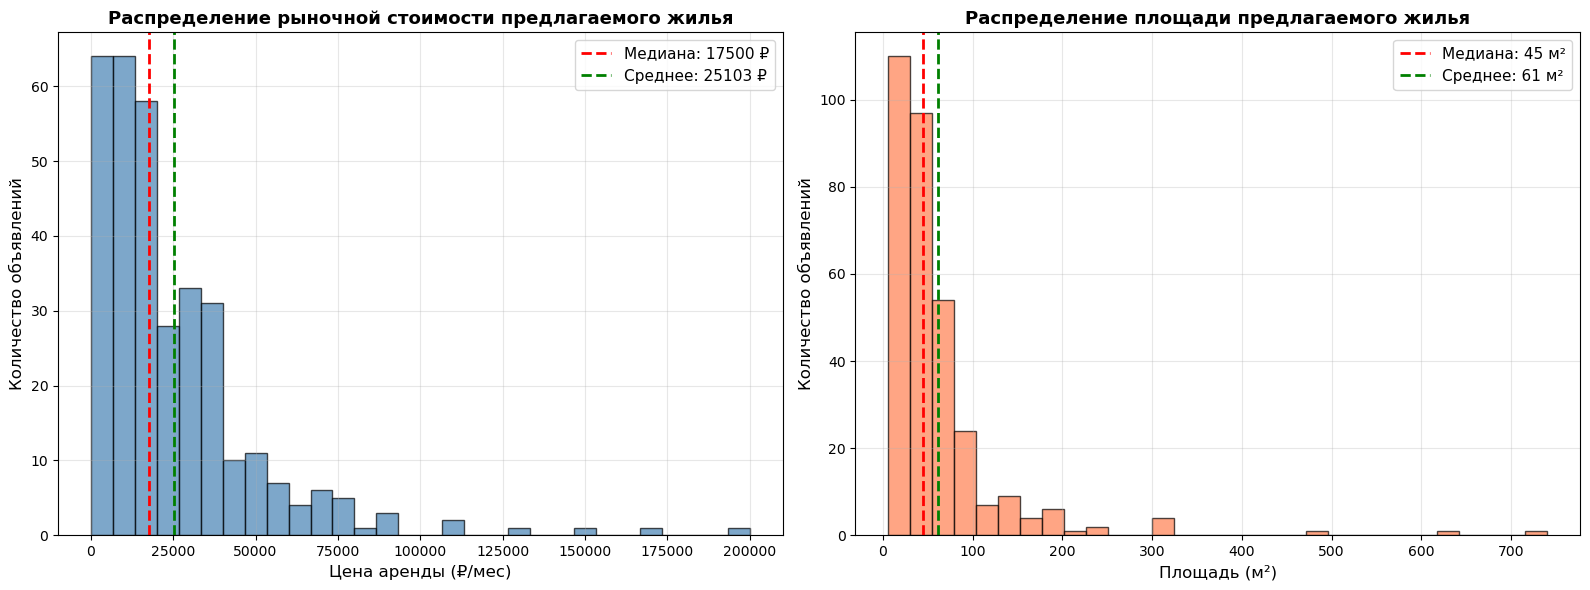

In [35]:
#Визуализация распределения цен и площади
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Гистограмма цен
axes[0].hist(df_final['Цена (₽/мес)'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_final['Цена (₽/мес)'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Медиана: {df_final["Цена (₽/мес)"].median():.0f} ₽')
axes[0].axvline(df_final['Цена (₽/мес)'].mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Среднее: {df_final["Цена (₽/мес)"].mean():.0f} ₽')
axes[0].set_xlabel('Цена аренды (₽/мес)', fontsize=12)
axes[0].set_ylabel('Количество объявлений', fontsize=12)
axes[0].set_title('Распределение рыночной стоимости предлагаемого жилья', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

#Гистограмма площади
axes[1].hist(df_final['Площадь (м²)'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(df_final['Площадь (м²)'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Медиана: {df_final["Площадь (м²)"].median():.0f} м²')
axes[1].axvline(df_final['Площадь (м²)'].mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Среднее: {df_final["Площадь (м²)"].mean():.0f} м²')
axes[1].set_xlabel('Площадь (м²)', fontsize=12)
axes[1].set_ylabel('Количество объявлений', fontsize=12)
axes[1].set_title('Распределение площади предлагаемого жилья', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
type_counts = df_final['Тип жилья'].value_counts()
print((type_counts / type_counts.sum() * 100).round(1))

Дома        41.7
Квартиры    29.6
Комнаты     28.7
Name: Тип жилья, dtype: float64


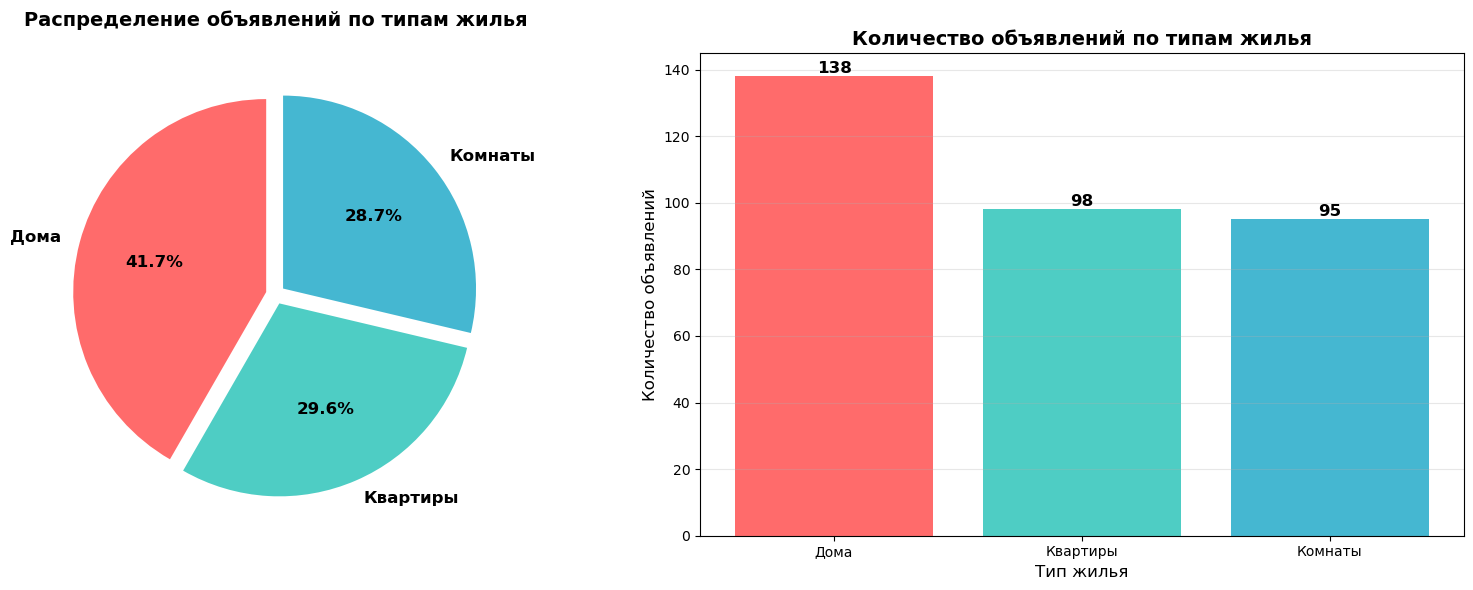

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Круговая диаграмма
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
explode = (0.05, 0.05, 0.05)  #Слегка "выдвигаем" все сектора

axes[0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Распределение объявлений по типам жилья', fontsize=14, fontweight='bold', pad=20)

#Столбчатая диаграмма
bars = axes[1].bar(type_counts.index, type_counts.values, color=colors, linewidth=1.5)
axes[1].set_ylabel('Количество объявлений', fontsize=12)
axes[1].set_xlabel('Тип жилья', fontsize=12)
axes[1].set_title('Количество объявлений по типам жилья', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

#Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Ключевые наблюдения:**

Наибольшее количество предложений приходится на дома. Это может объясняться:
- Большей доступностью данного типа жилья для краткосрочной помощи
- Экономическими соображениями владельцев
- Спецификой региональных рынков недвижимости

### 2.2. Анализ пропущенных значений

In [43]:
missing_data = pd.DataFrame({
    'Столбец': df_final.columns,
    'Пропущено': df_final.isnull().sum().values,
    'Процент (%)': (df_final.isnull().sum().values / len(df) * 100).round(2)})

missing_data = missing_data[missing_data['Пропущено'] > 0].sort_values('Пропущено', ascending=False)

if len(missing_data) > 0:
    display(missing_data)
else:
    print("Пропущенных значений не обнаружено")

,Столбец,Пропущено,Процент (%)
4,Комнаты,157,46.45
5,Площадь (м²),10,2.96
8,Дата публикации,1,0.30


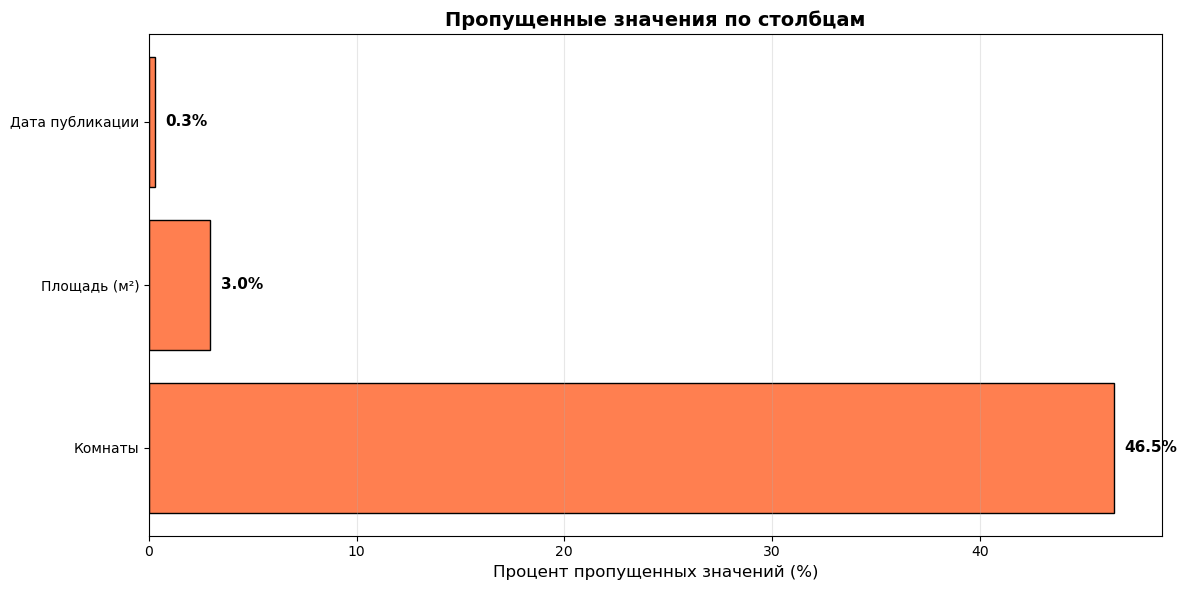

In [44]:
#Визуализация пропущенных значений
if len(missing_data) > 0:
    plt.figure(figsize=(12, 6))
    bars = plt.barh(missing_data['Столбец'], missing_data['Процент (%)'], color='coral', edgecolor='black')
    plt.xlabel('Процент пропущенных значений (%)', fontsize=12)
    plt.title('Пропущенные значения по столбцам', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, v) in enumerate(zip(bars, missing_data['Процент (%)'].values)):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.show()

**Интерпретация пропущенных данных:**

- **Столбец "Комнаты":** Пропущенные значения характерны для категории "Дома", где количество комнат не всегда указывается в объявлениях. Это связано со спецификой описания частных домов на платформе Avito.

- Остальные столбцы имеют высокую степень заполненности, что говорит о качестве собранных данных.

## 2.3 География цифровой солидарности

#### Топ-15 регионов по количеству предложений

In [47]:
#Анализ регионов
top_regions = df_final['Регион'].value_counts().head(15)

print(f"\n{'№':>3} | {'Регион':<45} | {'Объявлений':>11} | {'Доля (%)':>10}")

for i, (region, count) in enumerate(top_regions.items(), 1):
    percentage = count / len(df) * 100
    print(f"{i:>3} | {region:<45} | {count:>11} | {percentage:>9.1f}%")

print("=" * 80)
print(f"Всего уникальных регионов: {df_final['Регион'].nunique()}")


  № | Регион                                        |  Объявлений |   Доля (%)
  1 | Московская                                    |          44 |      13.0%
  2 | Краснодарский                                 |          38 |      11.2%
  3 | Москва                                        |          19 |       5.6%
  4 | Ленинградская                                 |          17 |       5.0%
  5 | Санкт-Петербург                               |          12 |       3.6%
  6 | Тверская                                      |           9 |       2.7%
  7 | Волгоградская                                 |           9 |       2.7%
  8 | Ростовская                                    |           9 |       2.7%
  9 | Тюменская                                     |           9 |       2.7%
 10 | Челябинская                                   |           8 |       2.4%
 11 | Свердловская                                  |           8 |       2.4%
 12 | Кемеровская — Кузбасс                        

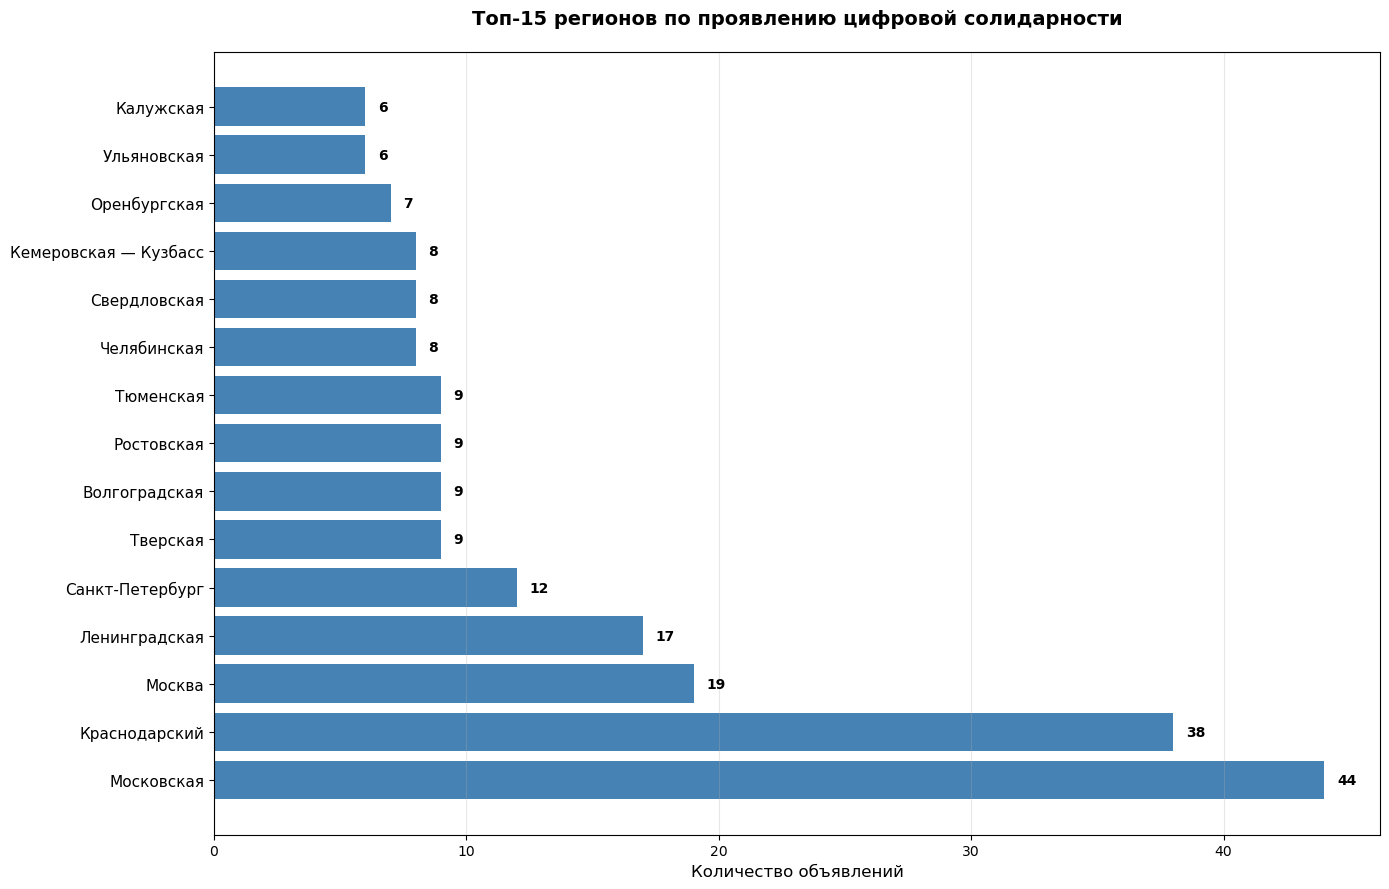

In [49]:
#Визуализация топ-15 регионов
plt.figure(figsize=(14, 9))
bars = plt.barh(range(len(top_regions)), top_regions.values, color='steelblue')
plt.yticks(range(len(top_regions)), top_regions.index, fontsize=11)
plt.xlabel('Количество объявлений', fontsize=12)
plt.title('Топ-15 регионов по проявлению цифровой солидарности', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

#Добавляем значения на столбцы
for i, (bar, v) in enumerate(zip(bars, top_regions.values)):
    plt.text(v + 0.5, i, str(v), va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

**Ключевые выводы по географии солидарности:**

1. **Лидеры по активности:** Московская область и Краснодарский край демонстрируют наибольшую активность в предоставлении бесплатного жилья, что может быть связано как с большим количеством доступного жилья, так и с высоким уровнем гражданской активности.

2. **География распространения:** Помощь предлагается из 65 различных регионов России, что свидетельствует о широком географическом охвате инициативы.

3. **Столичные регионы:** Москва и Санкт-Петербург также входят в топ по количеству предложений, что может быть связано с большим количеством доступного жилья и развитой цифровой инфраструктурой.

## 2.4. Условия помощи: анализ сроков бесплатного проживания

#### Общее распределение по срокам

In [50]:
#Распределение по срокам
period_stats = df_final['Срок помощи'].value_counts().sort_values(ascending=False)

print(f"\n{'Срок проживания':<25} | {'Объявлений':>12} | {'Доля (%)':>10}")
print("-" * 80)

for period, count in period_stats.items():
    percentage = count / len(df) * 100
    print(f"{period:<25} | {count:>12} | {percentage:>9.1f}%")

print("=" * 80)


Срок проживания           |   Объявлений |   Доля (%)
--------------------------------------------------------------------------------
Более 2 месяцев           |          187 |      55.3%
1 неделя                  |           73 |      21.6%
1 месяц                   |           42 |      12.4%
2 месяца                  |           16 |       4.7%
2 недели                  |           13 |       3.8%


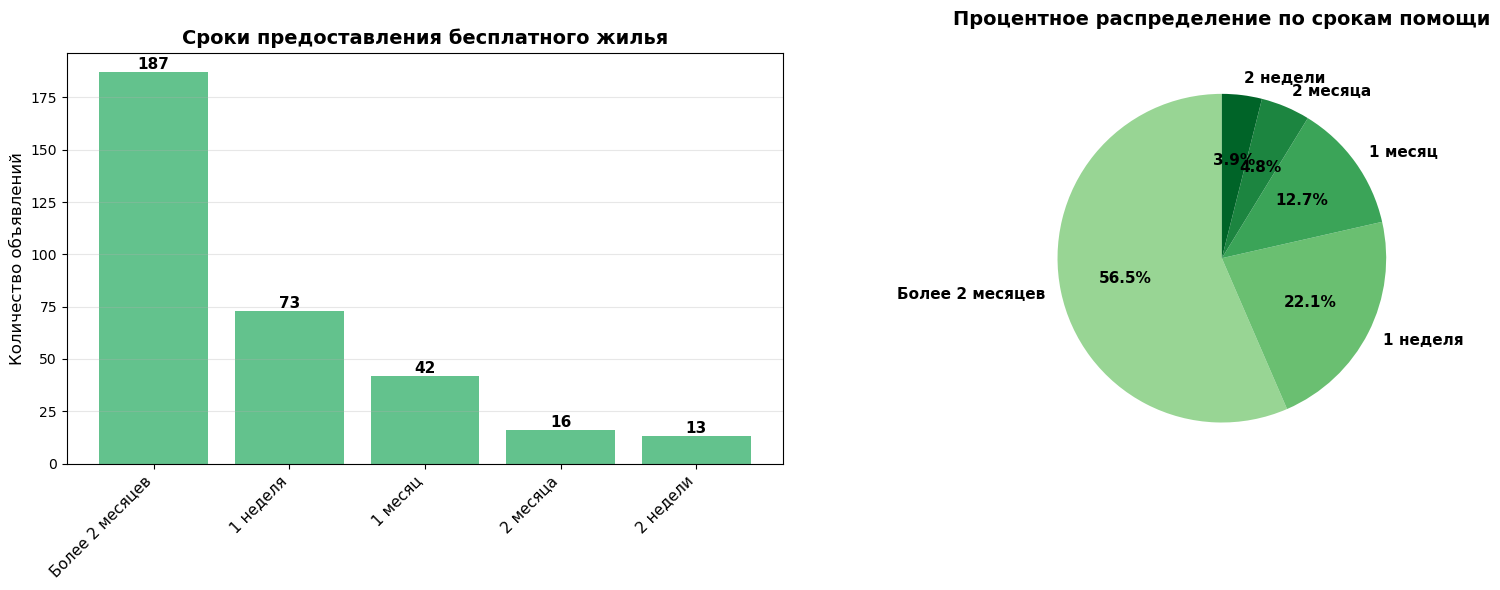

In [52]:
#Визуализация сроков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Столбчатая диаграмма
bars = axes[0].bar(range(len(period_stats)), period_stats.values, 
                   color='mediumseagreen', alpha=0.8, linewidth=1.5)
axes[0].set_xticks(range(len(period_stats)))
axes[0].set_xticklabels(period_stats.index, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel('Количество объявлений', fontsize=12)
axes[0].set_title('Сроки предоставления бесплатного жилья', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

#Круговая диаграмма
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(period_stats)))
axes[1].pie(period_stats.values, labels=period_stats.index, autopct='%1.1f%%',
           startangle=90, colors=colors, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Процентное распределение по срокам помощи', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

**Интерпретация:**

- **Долгосрочная помощь:** Значительная доля объявлений 56.5% предлагает жильё на срок более 2 месяцев, что свидетельствует о готовности граждан к длительной поддержке вынужденных переселенцев.

- **Краткосрочная помощь:** 25.4% готовы помочь на 1-2 недели, что может быть оптимально для первичного размещения и поиска постоянного жилья.

- **Выводы о готовности к помощи:** Преобладание долгосрочных предложений показывает высокий уровень гражданской ответственности и готовности к существенной безвозмездной помощи.

#### Связь между типом жилья и сроком помощи

In [53]:
#Кросс-табуляция
cross_tab = pd.crosstab(df_final['Тип жилья'], df_final['Срок помощи'], margins=True)
display(cross_tab)

Срок помощи,1 месяц,1 неделя,2 месяца,2 недели,Более 2 месяцев,All
Тип жилья,,,,,,
Дома,16,25,6,1,90,138
Квартиры,14,36,4,6,38,98
Комнаты,12,12,6,6,59,95
All,42,73,16,13,187,331


In [54]:
#Нормализованная таблица (проценты по строкам)
cross_tab_norm = pd.crosstab(df_final['Тип жилья'], df_final['Срок помощи'], normalize='index') * 100

print("\nПроцентное распределение сроков помощи по типам жилья:")
print("(% от общего числа объявлений каждого типа)")
display(cross_tab_norm.round(1))


Процентное распределение сроков помощи по типам жилья:
(% от общего числа объявлений каждого типа)


Срок помощи,1 месяц,1 неделя,2 месяца,2 недели,Более 2 месяцев
Тип жилья,,,,,
Дома,11.6,18.1,4.3,0.7,65.2
Квартиры,14.3,36.7,4.1,6.1,38.8
Комнаты,12.6,12.6,6.3,6.3,62.1


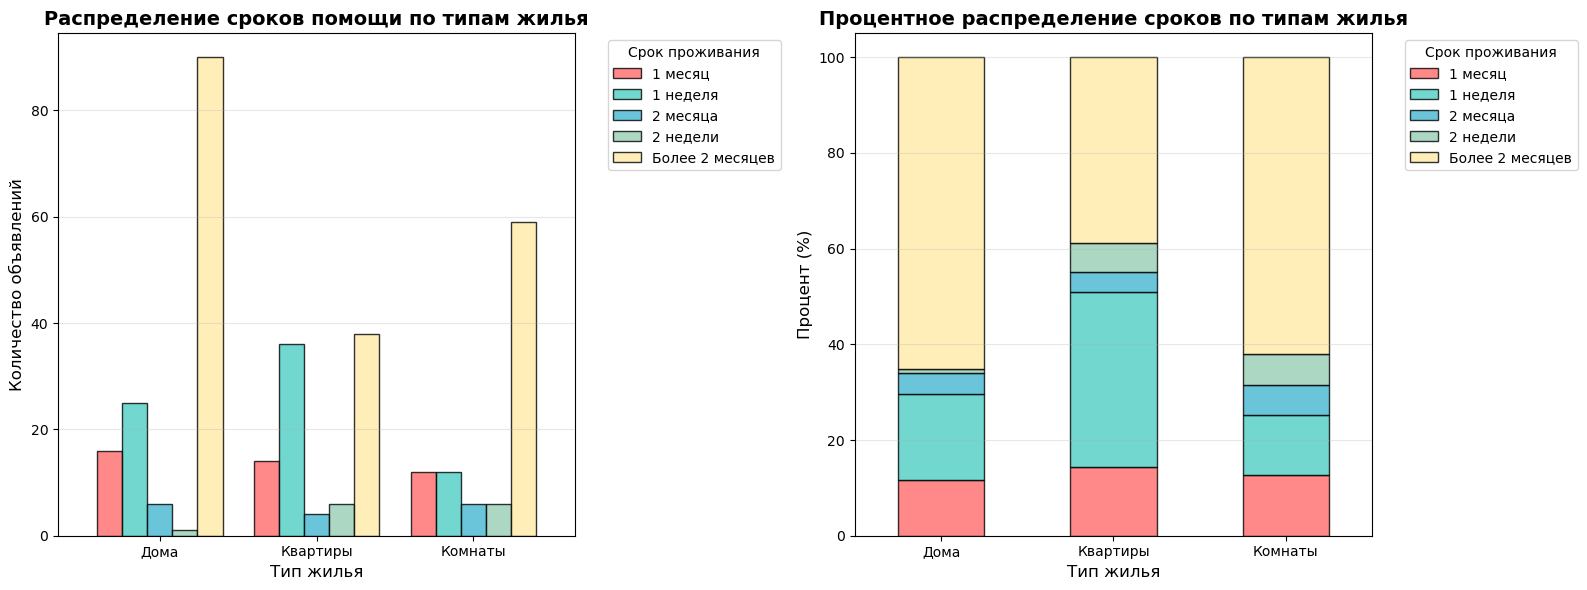

In [55]:
cross_tab_plot = pd.crosstab(df_final['Тип жилья'], df_final['Срок помощи'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Сгруппированная столбчатая диаграмма
cross_tab_plot.plot(kind='bar', ax=axes[0], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],
                    edgecolor='black', alpha=0.8, width=0.8)
axes[0].set_xlabel('Тип жилья', fontsize=12)
axes[0].set_ylabel('Количество объявлений', fontsize=12)
axes[0].set_title('Распределение сроков помощи по типам жилья', fontsize=14, fontweight='bold')
axes[0].legend(title='Срок проживания', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

#Stacked bar chart (нормализованный)
cross_tab_norm.plot(kind='bar', stacked=True, ax=axes[1],
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],
                   edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Тип жилья', fontsize=12)
axes[1].set_ylabel('Процент (%)', fontsize=12)
axes[1].set_title('Процентное распределение сроков по типам жилья', fontsize=14, fontweight='bold')
axes[1].legend(title='Срок проживания', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Ключевые выводы:**

- **Квартиры:** Наиболее часто предлагаются на не на очень длительный срок, что может быть связано с экономической целесообразностью краткосрочной аренды.

- **Дома:** Показывают большую готовность к долгосрочной помощи (более 2 месяцев), что может объясняться большей площадью и возможностью размещения семей.

- **Комнаты:** Преимущественно предлагаются на длительный срок.

## 2.5. Характеристики предлагаемого жилья

####  Средние характеристики по типам жилья

In [61]:
characteristics = df_final.groupby('Тип жилья').agg({
    'Цена (₽/мес)': ['mean', 'median', 'min', 'max'],
    'Площадь (м²)': ['mean', 'median', 'min', 'max']
}).round(0)
display(characteristics)

Цена (₽/мес)                        Площадь (м²)                    
                  mean   median   min     max         mean median   min    max
Тип жилья                                                                     
Дома           31362.0  20000.0     1  200000         93.0   64.0  12.0  740.0
Квартиры       29430.0  29000.0  1000   90000         52.0   44.0  15.0  480.0
Комнаты        11548.0  10500.0    15   40000         18.0   17.0   6.0   61.0

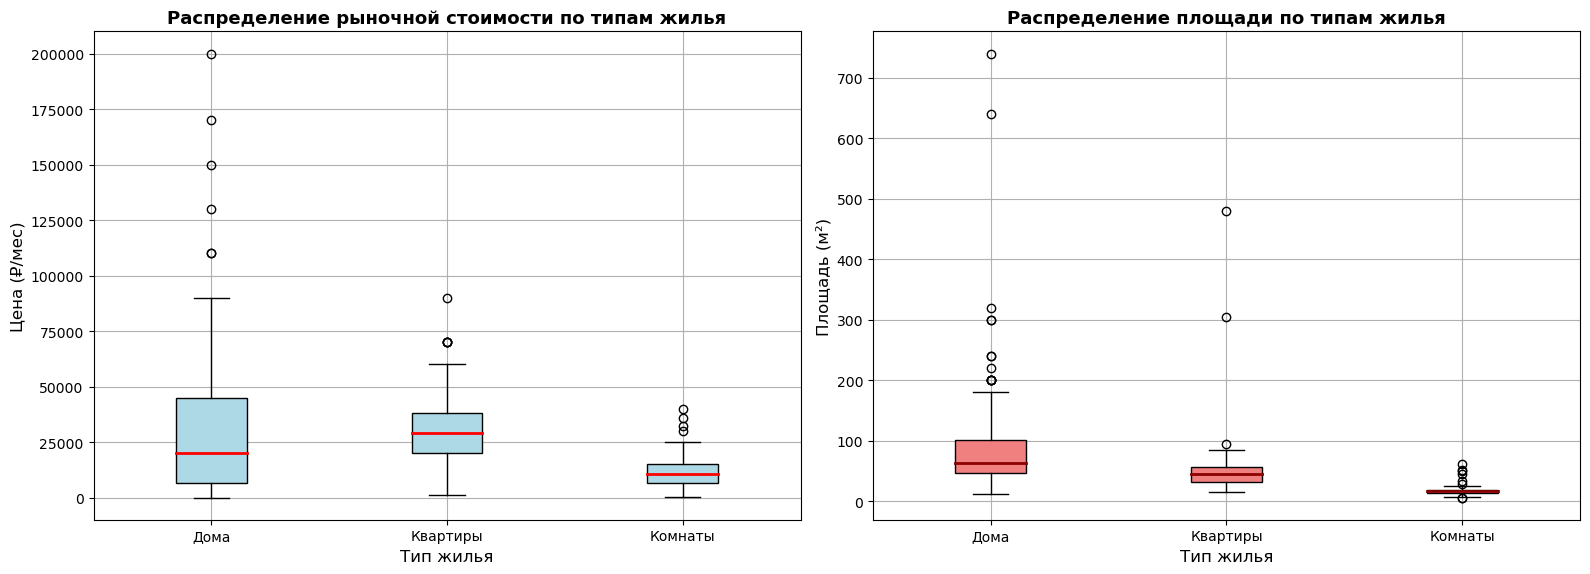

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Boxplot для цен
df_final.boxplot(column='Цена (₽/мес)', by='Тип жилья', ax=axes[0], patch_artist=True,
          boxprops=dict(facecolor='lightblue', color='black'),
          medianprops=dict(color='red', linewidth=2),
          whiskerprops=dict(color='black'),
          capprops=dict(color='black'))
axes[0].set_title('Распределение рыночной стоимости по типам жилья', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Тип жилья', fontsize=12)
axes[0].set_ylabel('Цена (₽/мес)', fontsize=12)
plt.sca(axes[0])
plt.xticks(rotation=0)

#Boxplot для площади
df_final.boxplot(column='Площадь (м²)', by='Тип жилья', ax=axes[1], patch_artist=True,
          boxprops=dict(facecolor='lightcoral', color='black'),
          medianprops=dict(color='darkred', linewidth=2),
          whiskerprops=dict(color='black'),
          capprops=dict(color='black'))
axes[1].set_title('Распределение площади по типам жилья', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Тип жилья', fontsize=12)
axes[1].set_ylabel('Площадь (м²)', fontsize=12)
plt.sca(axes[1])
plt.xticks(rotation=0)

plt.suptitle('') 
plt.tight_layout()
plt.show()

**Выводы по характеристикам жилья:**

- **Ценовой диапазон:** Средняя рыночная стоимость предлагаемого бесплатно жилья составляет:
  - Квартиры: 29430 рублей в месяц
  - Комнаты: 11548 рублей в месяц
  - Дома: 31362 рублей в месяц

- **Диапазон площади жилья:** Средняя площадь предлагаемого бесплатно жилья составляет:
  - Квартиры: 52 м² 
  - Комнаты: 93 м²
  - Дома: 18 м²

1         46
2         68
3         27
4          7
5          4
7          1
8          4
9          2
студия    15
Name: Комнаты, dtype: int64


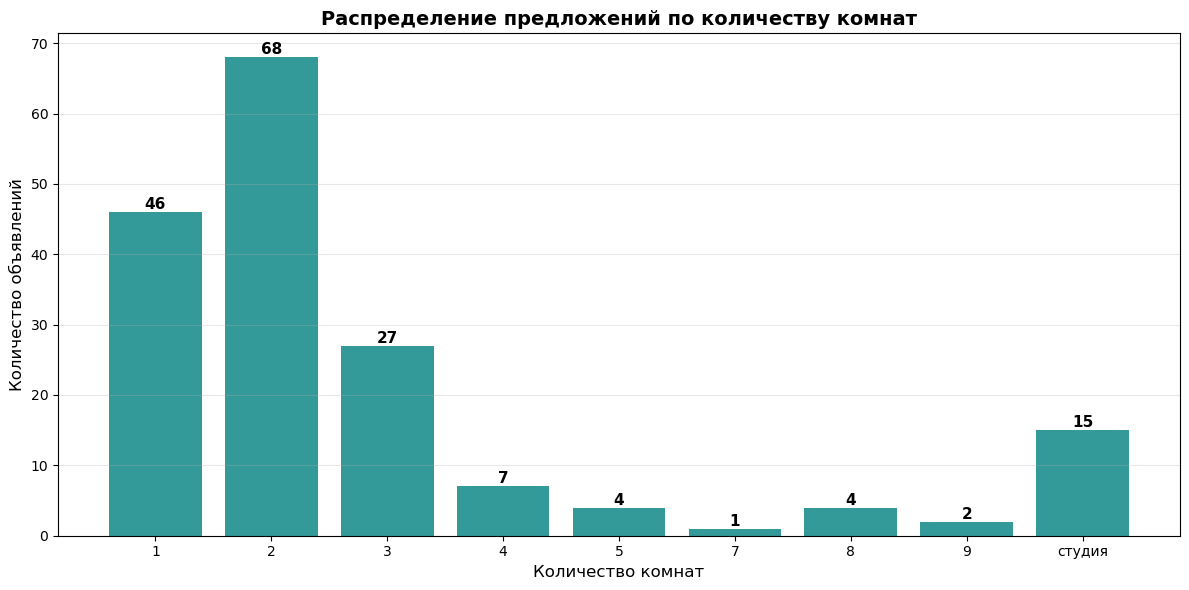

In [66]:
#Анализ количества комнат (только для квартир и комнат)
rooms_data = df_final[df_final['Комнаты'].notna()]

if len(rooms_data) > 0:
    rooms_counts = rooms_data['Комнаты'].value_counts().sort_index()
    print(rooms_counts)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(rooms_counts.index.astype(str), rooms_counts.values, 
                   color='teal', alpha=0.8)
    plt.xlabel('Количество комнат', fontsize=12)
    plt.ylabel('Количество объявлений', fontsize=12)
    plt.title('Распределение предложений по количеству комнат', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

### 2.6 Комплексно для регионов лидеров

In [68]:
#Топ-5 регионов и их предпочтения по типам жилья
top5_regions = df_final['Регион'].value_counts().head(5).index
df_top5 = df_final[df_final['Регион'].isin(top5_regions)]

#Кросс-табуляция
region_type_cross = pd.crosstab(df_top5['Регион'], df_top5['Тип жилья'])
display(region_type_cross)

Тип жилья,Дома,Квартиры,Комнаты
Регион,,,
Краснодарский,15,17,6
Ленинградская,13,2,2
Москва,1,1,17
Московская,17,5,22
Санкт-Петербург,1,4,7


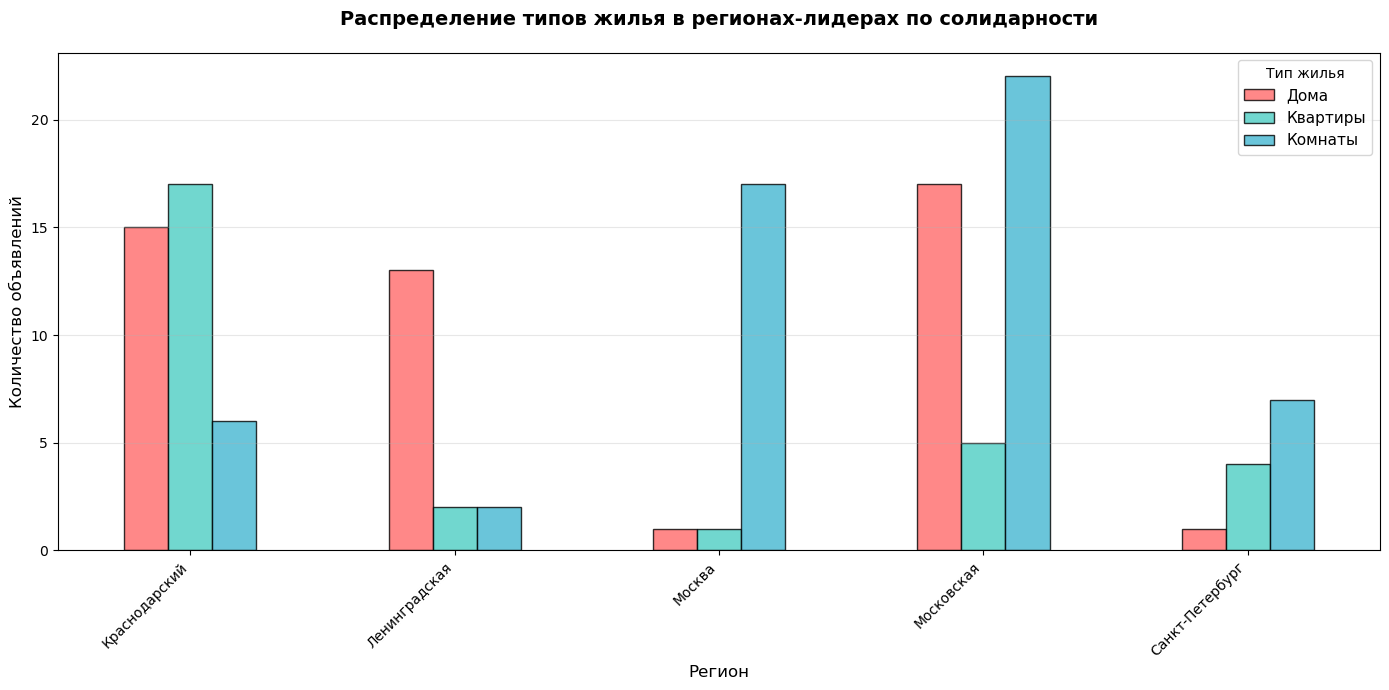

In [70]:
region_type_cross.plot(kind='bar', figsize=(14, 7), 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                       edgecolor='black', alpha=0.8)
plt.xlabel('Регион', fontsize=12)
plt.ylabel('Количество объявлений', fontsize=12)
plt.title('Распределение типов жилья в регионах-лидерах по солидарности', fontsize=14, fontweight='bold', pad=20)
plt.legend(title='Тип жилья', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()